# **The Stokes equations - adaptive mesh refinement**
Template by **Johan Hoffman**

Lab report by **Giuseppe Anagni**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2024-04-21 19:09:10--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-04-21 19:09:10 (38.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5182fde/releases/pybind11-inst

# **Introduction**

The Stokes equations take the form

$$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$$
u=g_D,\quad x\in \Gamma_D
$$

$$
u=0,\quad x\in \Gamma_F
$$

$$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$,
which generates the adjoint Stokes equations

$$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$$

together with boundary conditions that reflect the primal equations and the chosen functional.

$$
\varphi=0,\quad x\in \Gamma_D
$$

$$
\varphi=\psi_3,\quad x\in \Gamma_F
$$

$$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

$${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K,$$

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$$
R_1(U,P) = f + \Delta U - \nabla P
$$

$$
R_2(U) = \nabla \cdot U
$$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

Two functions are defined in order to explore different settings of the Stokes problem and investigate the adaptive mesh refinement capabilities of the solver in the **Results** section.

The function $\texttt{domain}$ takes as input the position $\texttt{xc}$, $\texttt{yc}$ of the circle in the $4\times4$ square domain, as well as the desired $\texttt{resolution}$ of the mesh and generates an initial meshed domain.

Such inital $\texttt{mesh_init}$ is then taken as an argument by the function $\texttt{lab3}$, together with the polynomial order of the primal ($\texttt{nvp}, \texttt{nqp}$) and adjoint ($\texttt{nva}, \texttt{nqa}$) finite element spaces for both velocity and pressure.

The data to the adjoint problem in the form of the functional $\psi_1,\psi_2,\psi_3$ is varied through the boolean variables $\texttt{SetPsi}$ and $\texttt{SetDrag}$, that determine which case is considered.

The output of the function is the refined mesh (triangles that have a local error higher than the average are refined by the code), as well as the primal and adjoint velocity and pressure fields. The total error is also computed.

In [3]:
########## Define domain and mesh ##########

def domain(resolution, xc, yc):

  ### Define square domain
  L = 4
  H = L

  # Define circle
  # xc = 0.5
  # yc = 0.5*H
  rc = 0.3

  # Generate mesh (examples with and without a hole in the mesh)
  #resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  init_no_levels = 0
  for i in range(0,init_no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(0.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  return H, L, mesh

In [4]:
def lab3(H, L, mesh_init, nvp, nqp, nva, nqa, SetPsi, SetDrag):

  ########## Define finite element approximation spaces ##########
  mesh = mesh_init

  ### nvp, nqp (primal) = 2, 1 | nva, nqa (adjoint) = 3, 2
  # Generate mixed finite element spaces (for primal velocity and pressure)
  ### Primal problem (Taylor-Hood w/ inf-sup condition).
  VE = VectorElement("CG", mesh.ufl_cell(), nvp)
  QE = FiniteElement("CG", mesh.ufl_cell(), nqp)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W)

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  ### Adjoint problem, note that these approximations are of different order.
  ### The error estimate (weak residuals) is close to zero if same order is used.
  VEa = VectorElement("CG", mesh.ufl_cell(), nva)
  QEa = FiniteElement("CG", mesh.ufl_cell(), nqa)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  ########## Define boundary conditions ##########

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  ########## Define and solve variational problems ##########

  # Set boundary penalty parameter gamma
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  if SetPsi:
    psi1 = Expression(("0.0","0.0"), element = V.ufl_element()) ### Velocity
    psi2 = Expression("0.0", element = Q.ufl_element()) ### Pressure
  else:
    psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element()) ### Velocity
    psi2 = Expression("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element()) ### Pressure

  if SetDrag and SetPsi:
    phi3 = Expression(("1.0","0.0"), element = V.ufl_element()) ### Force (drag)
  elif not SetDrag and SetPsi:
    phi3 = Expression(("0.0","1.0"), element = V.ufl_element()) ### Force (lift)
  else:
    phi3 = Expression(("0.0","0.0"), element = V.ufl_element()) ### Force

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  ### Weak residual of primal problem
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system
  solve(res == 0, w)

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  ### Weak residual of adjoint problem
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system
  solve(res_a == 0, wa)

  ########## Visualize solution and export files ##########

  #!rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

  ########## Compute error indicators ##########

  # Define function space over the elements of the mesh
  ### Discontinuous Galerkin (DG) approximation of zeroth order
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  ### Refine triangles that have a local error higher than the average
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()]
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  # plt.figure()
  # plot(mesh)
  # plt.show()

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  ### Sum of total errors
  tot_err = assemble(err_ind_sum)
  #s = 'Total error = ' + repr(tot_err)
  #print(s)

  return u_fcn, p_fcn, phi_fcn, theta_fcn, mesh, tot_err

# **Results**

The function $\texttt{lab3}$ is first called for arguments relative to the flow around the circle in three different positions in the square domain:
$$(x_c,y_c)=(1,2)\,,(2,2)\,,(3,0.5).$$

For these cases, the functional is set equal to the drag force:
$$\psi_1 = (0,0)\quad \psi_2 = 0 \quad \psi_3 = (1,0).$$

The primal and adjoint solutions for the velocity and pressure fields are visualized and so are the initial and refined meshes for each case.



In [5]:
xc = [0.7, 2, 3]
yc = [2, 2, 1]
for k in range(3):
  [H, L, Mesh_init] = domain(32, xc[k], yc[k])
  [U, P, Phi, Theta, Mesh_refin, Error] = lab3(H, L, Mesh_init, 2, 1, 3, 2, True, True)

  fig, axs = plt.subplots(1, 2, figsize=(10, 12))
  plt.sca(axs[0])
  plot(Mesh_init, title="Initial mesh, $Resolution=32$")
  plt.sca(axs[1])
  plot(Mesh_refin, title="Refined mesh")

  fig, axs = plt.subplots(1, 2, figsize=(10, 12))
  plt.sca(axs[0])
  plot(U, title="Velocity")
  plt.sca(axs[1])
  plot(P, title="Pressure")

  fig, axs = plt.subplots(1, 2, figsize=(10, 12))
  plt.sca(axs[0])
  plot(Phi, title="Adjoint velocity")
  plt.sca(axs[1])
  plot(Theta, title="Adjoint pressure")

  plt.show()
  print("The total error is: " + repr(Error))

Output hidden; open in https://colab.research.google.com to view.

The function is called again, now with a constant circle position at $(2,2)$ and varying the functional twice.

Compared to the previous solution involving the drag force, now the lift force is considered first:
$$\psi_1 = (0,0)\quad \psi_2 = 0 \quad \psi_3 = (0,1),$$

as well as a source term for velocity and pressure for the second case:
$$\psi_1 = (e^{-10(x-2)^2-10(y-1.5)^2},0)\quad \psi_2 = e^{-10(x-2)^2-10(y-1)^2} \quad \psi_3 = (0,0).$$

Note how the mesh gets refined in different areas now. Now these involve the proximity of the cylinder as well as the vicinity of the source term considered in the second case, or the upper and lower boundaries of the domain for the lift case.

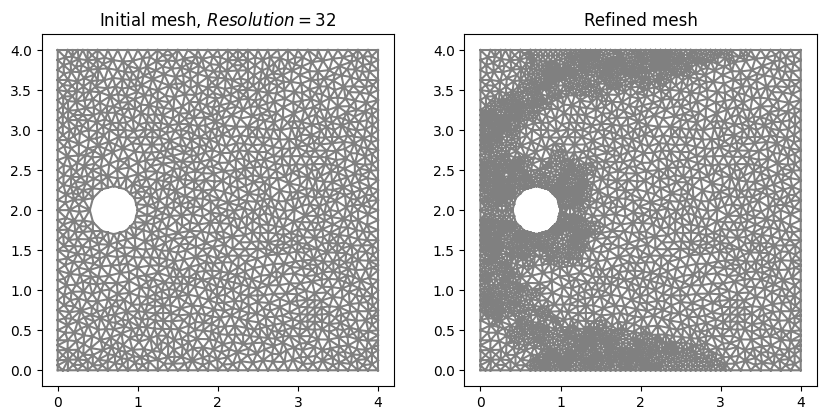

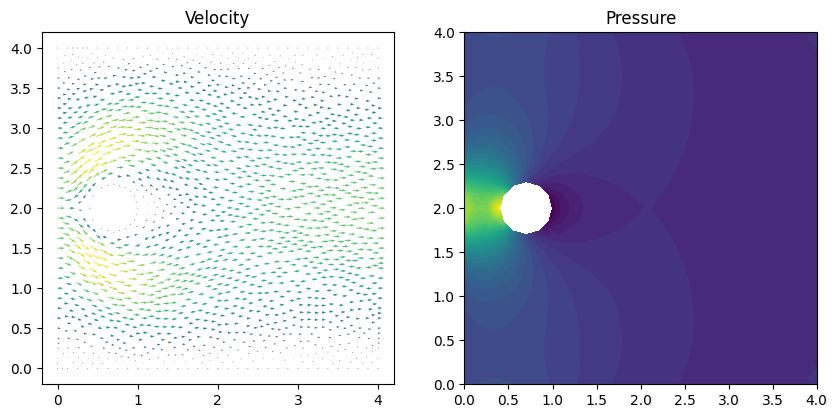

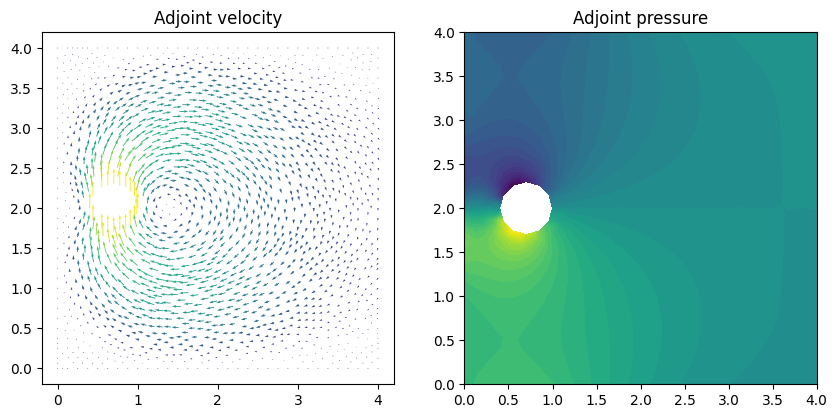

The total error is: 0.00039057105905844063


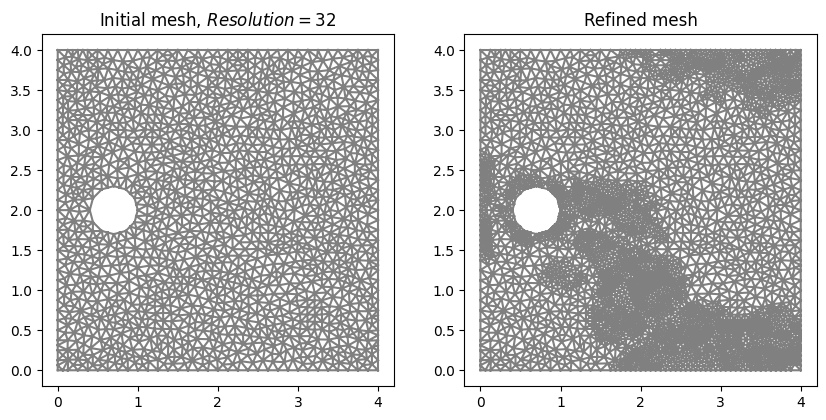

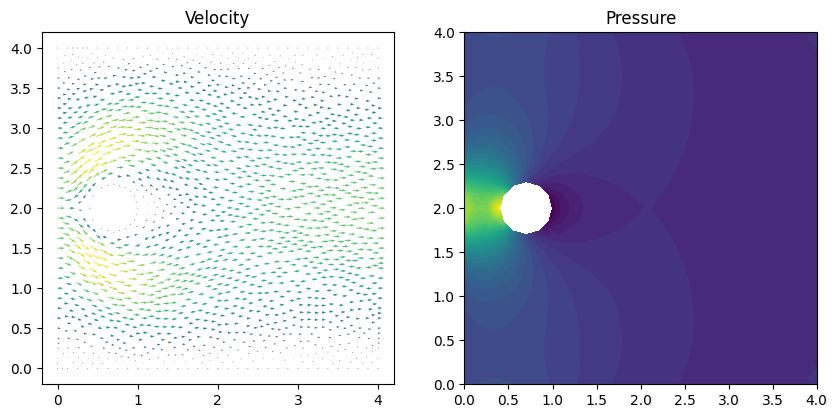

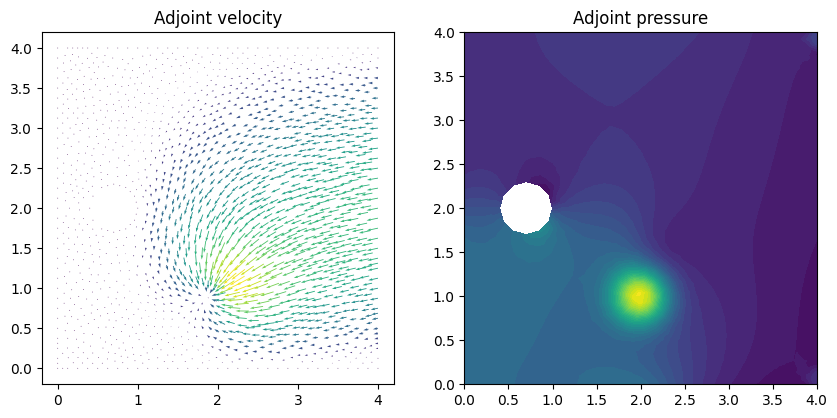

The total error is: -0.0002523918303864013


In [6]:
### Lift force

[H, L, Mesh_init] = domain(32, 0.7, 2)
[U, P, Phi, Theta, Mesh_refin, Error] = lab3(H, L, Mesh_init, 2, 1, 3, 2, True, False)

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Mesh_init, title="Initial mesh, $Resolution=32$")
plt.sca(axs[1])
plot(Mesh_refin, title="Refined mesh")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(U, title="Velocity")
plt.sca(axs[1])
plot(P, title="Pressure")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Phi, title="Adjoint velocity")
plt.sca(axs[1])
plot(Theta, title="Adjoint pressure")

plt.show()
print("The total error is: " + repr(Error))

### Source term

[H, L, Mesh_init] = domain(32, 0.7, 2)
[U, P, Phi, Theta, Mesh_refin, Error] = lab3(H, L, Mesh_init, 2, 1, 3, 2, False, False)

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Mesh_init, title="Initial mesh, $Resolution=32$")
plt.sca(axs[1])
plot(Mesh_refin, title="Refined mesh")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(U, title="Velocity")
plt.sca(axs[1])
plot(P, title="Pressure")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Phi, title="Adjoint velocity")
plt.sca(axs[1])
plot(Theta, title="Adjoint pressure")

plt.show()
print("The total error is: " + repr(Error))

In the previous examples, note how the error is quite small but not really close to zero.

Now, the drag case is selected and the orders for the primal and ajoint problems are made equal. The total error now appears way smaller, approaching zero with machine precision.

In [7]:
[H, L, Mesh_init] = domain(32, 0.7, 2)
[U, P, Phi, Theta, Mesh_refin, Error] = lab3(H, L, Mesh_init, 2, 1, 2, 1, True, True)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5472f199874f1ab06b4971d02c9293374dd3095c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              7
  Coefficients:                        '[f_781, f_785, f_787, f_788, f_790, f_791, f
                                       _792]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a4e4a8c9a4e04cc3bf58fa52e9f16e5bc3741ba1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              3
  Coefficients:                        '[f_785, f_787, f_788]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?
                         

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1087740200311502893630fbca8f5c21b2ba437d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_772, f_781, f_789]'
  Unique elements:           'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG1(?,?), CG2(?,
                             ?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f99522581b9b95e1532d31e502cca7630674d816

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              7
  Coefficients:                        '[f_772, f_781, f_784, f_785, f_787, f_788, f
                                       _789]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?

In [8]:
print("The total error is: " + repr(Error))

The total error is: -5.173906957164562e-13


This follows from the approximation of the solution to the exact adjoint problem, but does not represent the reality of the flow problem.

Instead, the function is called again for an increased polynomial order of the adjoint finite element spaces and the error is made smaller by increasing the mesh resolution, which contitutes a true reduction of the error.

In fact, in the previous case with $h=1/32$, the total error was $\simeq 0.019$, while it's decreased by one order of magnitude to $\simeq 0.0013$ for the finer mesh case, confirming its greater accuracy.

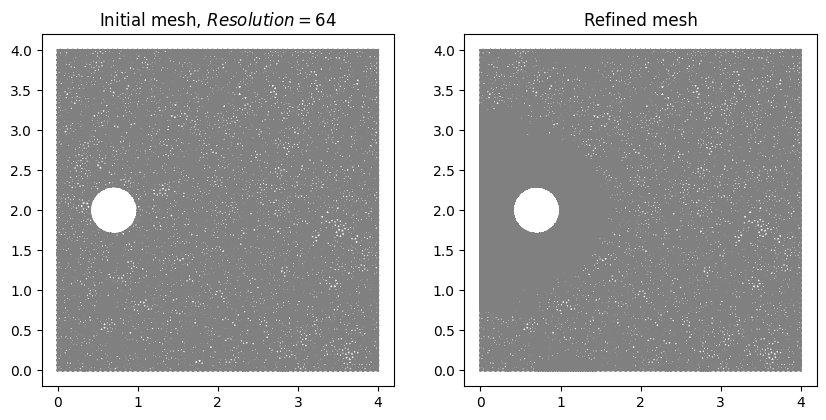

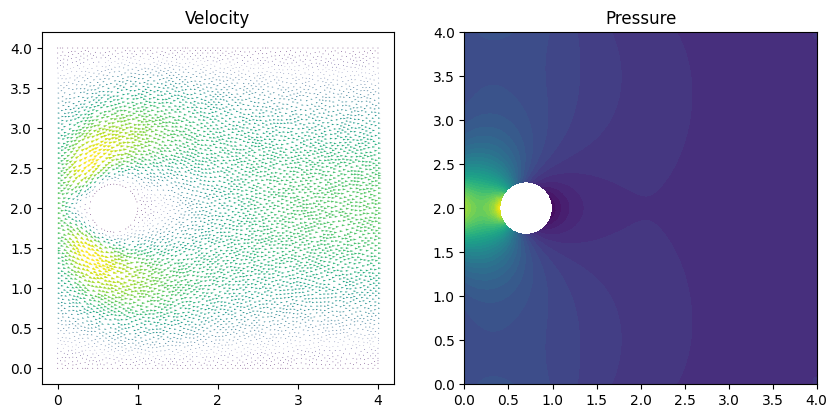

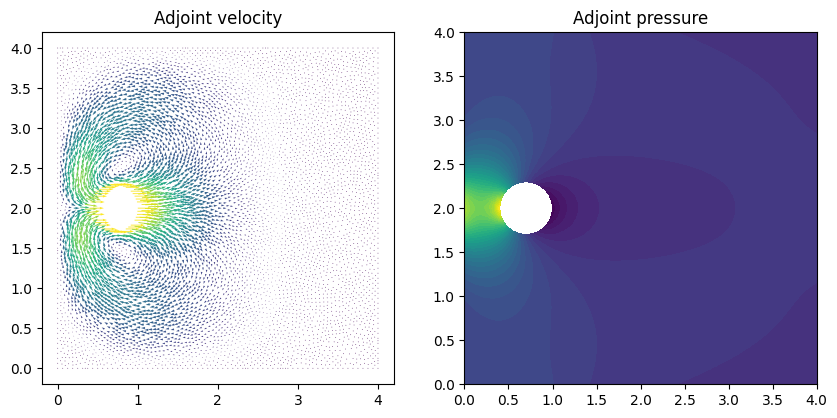

In [9]:
[H, L, Mesh_init] = domain(64, 0.7, 2)
[U, P, Phi, Theta, Mesh_refin, Error] = lab3(H, L, Mesh_init, 2, 1, 3, 2, True, True)

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Mesh_init, title="Initial mesh, $Resolution=64$")
plt.sca(axs[1])
plot(Mesh_refin, title="Refined mesh")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(U, title="Velocity")
plt.sca(axs[1])
plot(P, title="Pressure")

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
plt.sca(axs[0])
plot(Phi, title="Adjoint velocity")
plt.sca(axs[1])
plot(Theta, title="Adjoint pressure")

In [10]:
print("The total error is: " + repr(Error))

The total error is: 0.0013065133240970758


# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

The error total was found to decrease for an increase in the mesh resolution, as expected, while the mesh was observed to be refined in the most significative areas of the domain: this heavily depends on the obstacle position, as well as the considered functionals.